In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from scipy.integrate import quad, trapz
import scipy.stats as stats

In [2]:
# Definición de variables eV

k = 1.380649e-23    # J / K
h = 6.62607015e-34  # J*s
h_bar = h/(2*np.pi) # J*s
m = 0.5*9.1e-31     # kg
q = 1.602176e-19    # C

Ec = -4.7 * q       # J
Ef = -5.0 * q       # J

L = 40e-9           # m
W = 3*L             # m

alfa = L*W*m/(np.pi*h_bar*h_bar)

C_g = 0.1e-15       # F 
C_q = q*q*m*W*L/(2*np.pi*h_bar*h_bar)   # F

C_es = C_g + C_q

eta_0 = 1.0
eta = C_g/C_es

V_t = (Ec-Ef)/(q)

# Parte I

In [7]:

# Funciones de cálculo
def get_g(E, Ec): # g(E)dE eq 2.47 pag 70
    return (E >= Ec)


def fermi_dirac(E, T):
    return np.piecewise(E, [E<0, E>=0], [lambda x: 1/(1 + np.exp(x/(k*T))), lambda x: np.exp(-x/(k*T))/(1 + np.exp(-x/(k*T)))] )



def get_N(E, U, T, Vds):
    return 0.5 * alfa * np.trapz(get_g(E-U, Ec) * (fermi_dirac(E-Ef, T) + fermi_dirac(E-(Ef-Vds*q), T)), E)


def get_U(N, N_0, V_gs): # eq 5.33
    return q*q/C_es*(N-N_0)-V_gs*q


def get_I(E, U, T, Vds):
    y = np.sqrt(2*m*(E-Ec-U), where=E-Ec-U>=0) * get_g(E-U, Ec) * (fermi_dirac(E-Ef, T) - fermi_dirac(E-(Ef-Vds*q), T))
    return q*W / (np.pi*np.pi*h_bar*h_bar) * np.trapz(y, E)


# Loop de autoconsistencia
def solve_I(Vds, T, Vgs, U_guess = -0.3*q, tol = 1e-5, lr = 1e-3, disble = False):
    
    E = np.linspace(Ec*2, 0, 10000)

    N_0 = get_N(E = E, U = 0, T = T, Vds = 0)
    # print(f"N_0 = {N_0}")
    
    U_array = []
    error = []

    for _ in tqdm(range(int(1e4)), disable=disble):
        N_ = get_N(E, U_guess, T, Vds)
        # print(f"N = {N_}")
        U_formula = get_U(N_, N_0, Vgs)

        # print(f"U_={U_guess} \tU_computed={U_formula} \tN = {get_N(E, U_guess, T, Vds)}")

        U_array.append(U_formula)

        # print(U_)

        if abs(U_formula - U_guess) < tol:
            # print('Converged')
            break
        
        else:
            U_guess = U_guess + lr*(U_formula - U_guess)
            # print(f"lr*error = {lr*(U_computed - U_)}")


        error.append(abs(U_formula - U_guess))
    
    I_ = get_I(E, U_formula, T, Vds)
    # plt.plot(np.array(error)/q)
    # plt.yscale('log')
    # plt.xscale('log')

    
    return I_, U_array


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:07<00:00, 1379.58it/s]

262.6379772680104 -0.40519336662266625


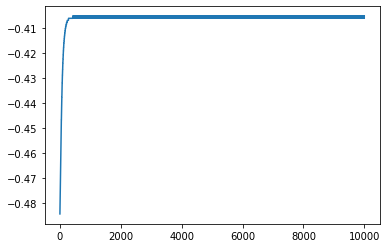

In [4]:
a = solve_I(Vds = 0.25, 
        T = 298, 
        Vgs = 0.5, 
        lr = 0.009,
        tol = 1e-4*q)
# print(U,I*1e6)
print(a[0]*1e6, a[1][-1]/q)

plt.plot(np.array(a[1])/q)
# N_0 = get_N(-0.5*eta*q, 298, 0)
# print(N_0)
    # print(f"N_0 = {N_0}")

In [51]:
def get_IVds(Vgs_array,T, tol = 1e-4*q, lr = 0.005):
    
    Vds_array = np.linspace(0, 0.5, 50)
    # Vgs_array = [0.3, 0.35, 0.4, 0.45, 0.5]    
    
    output = []

    U = -1*q    
    for Vgs in Vgs_array:
        Ids_array = []
        for i, Vds in enumerate(Vds_array):
            I, U_array  = solve_I(
                Vds = Vds,
                T = T,
                Vgs = Vgs,
                U_guess = U,
                lr = lr,
                tol = tol,
                disble=True
            )
            U = U_array[-1]
            Ids_array.append(I)

            if i % 10 == 0:
                print(i)
        output.append((Vds_array, Ids_array,Vgs))
    return output

def plot_IVds(data, T):
    plt.figure(figsize=(10,7))
    plt.title(f"Característica IV para T = {T} [K]")
    plt.ylabel(r"Drain Source current $(I_{DS})$ [uA]")
    plt.xlabel(r"Drain Source bias $(V_{DS})$ [V]")
    plt.ylim(0,50)
    plt.grid()
    for Vds_array, Ids_array, Vgs in data:
        plt.plot(Vds_array, np.array(Ids_array)*1e6, label = f'Vgs: {Vgs} V')
    plt.legend()
    plt.show()


In [27]:
Vgs_array = [0.3, 0.35] #0.45, 0.5]  
curves = get_IVds(Vgs_array,T = 1,)

0
10
20
30
40
0
10
20
30
40


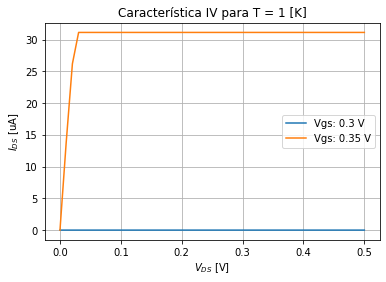

In [33]:
plot_IVds(curves, 1)

# Parte II

In [34]:
def I_lineal(Vds, V_gs): # eq 5.60
    cnt = q*W/(h_bar*h_bar*np.pi*np.pi)*np.sqrt(8*m/9)*np.sqrt(q*eta)**3
    # print(np.sqrt(V_gs-V_t-Vds/eta)**3, np.sqrt(V_gs-V_t)**3, cnt, cnt*(np.sqrt(V_gs-V_t)**3-np.sqrt(V_gs-V_t-Vds/eta)**3))
    return cnt*(np.sqrt(V_gs-V_t)**3-np.sqrt(V_gs-V_t-Vds/eta)**3)


def I_saturado(V_gs): # eq 5.61
    cnt =  q*W/(h_bar*h_bar*np.pi*np.pi)*np.sqrt(8*m/9)*np.sqrt(q*eta)**3
    return cnt*np.sqrt(V_gs-V_t)**3


# I_lineal = np.vectorize(I_lineal)
# I_saturado = np.vectorize(I_saturado)


In [41]:
Vds_array = np.linspace(0, 0.5, 1000)

def IVds_T0(Vgs, Vds_array):

    Ids_array = []

    for i, Vds in enumerate(Vds_array):
        if Vds < eta*(Vgs-V_t):
            I = I_lineal(Vds, Vgs)
        else:
            I = I_saturado(Vgs)
        Ids_array.append(I)
    
    return Ids_array

def get_IVds_T0(Vgs_array):

    data = []
    Vds_array = np.linspace(0, 0.5, 50)
    plt.figure()
    for Vgs in Vgs_array:
        Ids_array = IVds_T0(Vgs, Vds_array)
        data.append((Vds_array, Ids_array, Vgs))
    
    return data
    


<Figure size 432x288 with 0 Axes>

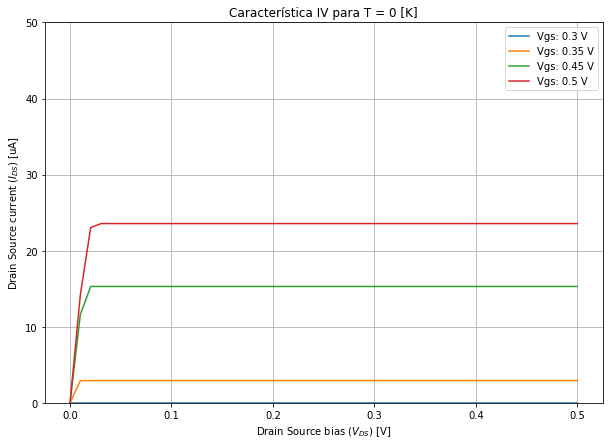

In [52]:
Vgs_array = [0.3, 0.35, 0.45, 0.5] 
data = get_IVds_T0(Vgs_array)
plot_IVds(data, 0)

# Parte III

In [60]:
def IVgs(Vds, T, tol = 1e-4*q, lr = 0.005):
    Vgs_array = np.linspace(0, 0.5, 100)

    Ids_array = []
    U = -1*q    
    for i, Vgs in enumerate(Vgs_array):
        I, U_array  = solve_I(
            Vds = Vds,
            T = T,
            Vgs = Vgs,
            U_guess = U,
            lr = lr,
            tol = tol,
            disble=True
        )
        U = U_array[-1]
        Ids_array.append(I)

        if i % 10 == 0:
            print(i)

    return Vgs_array, np.array(Ids_array)

voltage, current = IVgs(0.5, 298)
    
    

0
10
20
30
40
50
60
70
80
90


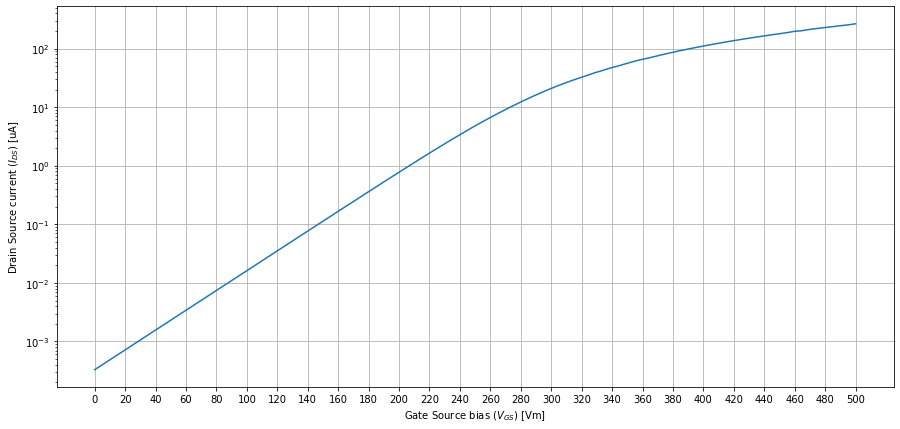

In [66]:
plt.figure(figsize=(15,7))
plt.plot(voltage*1e3, current*1e6)
plt.xticks(np.arange(min(voltage*1e3), max(voltage*1e3)+1, 20.0))
plt.xlabel(r"Gate Source bias $(V_{GS})$ [Vm]")
plt.ylabel(r"Drain Source current $(I_{DS})$ [uA]")
plt.yscale('log')
plt.grid()
plt.show()
